
<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/SMT_MFK_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div class="jumbotron text-left"><b>
This tutorial describes how to use the SMT toolbox with multifidelity data to build a surrogate model
SMT which is a python toolbox for building a surrogate model.</b></div>

Mostafa Meliani ISAE-SUPAERO student

Nathalie BARTOLI ONERA/DTIS/M2CI - May 2024
`version SMT 2.6 and above`, September 2024 with new plots

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md.
    The doc is available here: http://smt.readthedocs.io/en/latest/
</p>


For the multifidelity extension, a description of the algorithm is available here https://arc.aiaa.org/doi/pdf/10.2514/6.2019-3236

In [1]:
!pip install smt




# Multi-Fidelity Kriging

We are interested in learning a high-fidelity function while using low-fidelity information sources to enhance the model, for that we use Le Gratiet recursive formulation of multi-fidelity Kriging.

<p class="alert alert-warning" style="padding:1em">
An important assumption by using this recursive formulation is the nested DOE.
If we have thow fidelity levels (HF and LF)
$$X_{HF} \subset X_{LF}$$
 </p>   

### Kennedy O'Hagan/Le Gratiet recursive formulation:
To perform Le Gratiet's learning, we first learn the lowest fidelity, then we consecutively learn the relationship between every two consecutive fidelity levels (scaling factor $\rho_{k-1}$ and discrepancy function $\delta_k(\cdot)$).

$$\mu_{k} = \rho_{k-1}\;\mu_{k-1} + \mu_{\delta_k}\\
\sigma^2_{k} = \rho_{k-1}^2\;\sigma^2_{k-1}+\sigma^2_{\delta_k}$$

![Multi-Fidelity 1-D toy problem](https://github.com/SMTorg/smt/blob/master/tutorial/co-krigeage.png?raw=1)

This generally results in a better surrogate model compared to training the high-fidelity alone.

### SMT
SMT is a joint library between NASA, UoM, ONERA and ISAE-SUPAERO. It offers many surrogate modeling tools with a focus on derivatives. Le Gratiet's formulation was implemented as part of SMT.

After dowmloading and installing SMT library from: https://github.com/SMTorg/smt

We import the needed packages

In [11]:
from smt.applications import MFK
import numpy as np
from matplotlib import pyplot as plt
from smt.applications.mfk import NestedLHS
from smt.surrogate_models import KRG

%matplotlib inline

## 1- Build a multifidelity model using two fidelity levels

In [12]:
# defining low and high fidelity functions
def LF_function(x):
    return 0.5 * ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2) + (x - 0.5) * 10.0 - 5


def HF_function(x):
    return ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2)

Text(0, 0.5, '$y$')

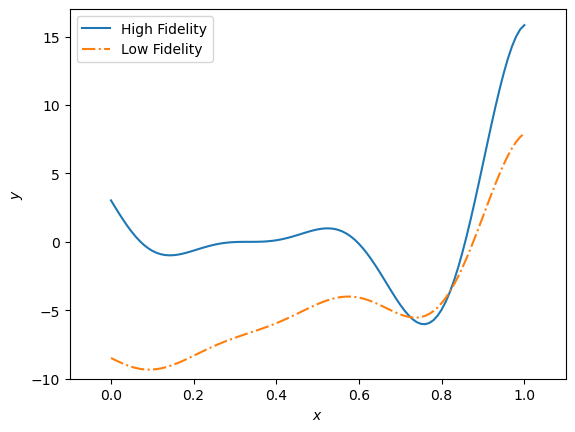

In [13]:
# Ploting High and low fidelity functions

x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
plt.figure()

plt.plot(x, HF_function(x), label="High Fidelity")
plt.plot(x, LF_function(x), linestyle="-.", label="Low Fidelity")

plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

#### Sampling
The idea when building a mutli-fidelity design of experiment is to cover as much space as possible with low-fidelity data and use enough high fidelity samples to learn the relationship between fidelity-levels.

Text(0, 0.5, '$y$')

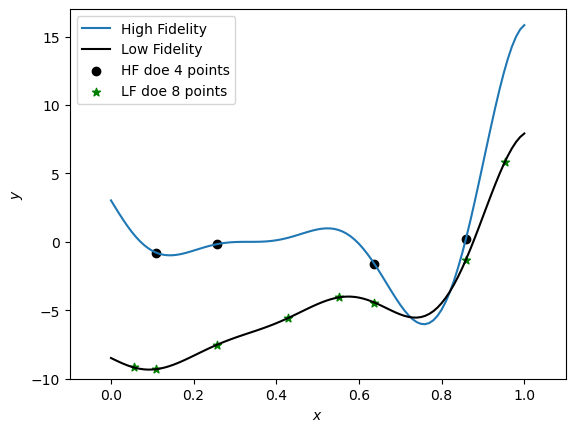

In [14]:
# LHS sampling with 2 levels of fidelity
ndim = 1  # 1 dimension example
nlvl = 2  # 2 levels
ndoe_HF = 4  # 4 high fidelity points

# Nested DOE
xlimits = np.array([[0.0, 1.0]])
xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits, random_state=2)
Xt_c, Xt_e = xdoes(ndoe_HF)
ndoe_LF = np.shape(Xt_c)[0]


# Evaluate the HF and LF functions
yt_e = HF_function(Xt_e)
yt_c = LF_function(Xt_c)

plt.plot(x, HF_function(x), label="High Fidelity")
plt.plot(x, LF_function(x), c="k", label="Low Fidelity")
legende_variable = "HF doe " + str(ndoe_HF) + " points"
plt.scatter(
    Xt_e, yt_e, marker="o", color="k", label="HF doe " + str(ndoe_HF) + " points"
)
plt.scatter(
    Xt_c, yt_c, marker="*", color="g", label="LF doe " + str(ndoe_LF) + " points"
)
plt.legend(loc=0)

plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

Building a SMT object has many options, you can check all the options in the doc website: http://smt.readthedocs.io

In [15]:
# build the MFK object
sm = MFK(theta0=Xt_e.shape[1] * [1.0])

# low-fidelity dataset names being integers from 0 to level -1
sm.set_training_values(Xt_c, yt_c, name=0)
# high-fidelity dataset without name
sm.set_training_values(Xt_e, yt_e)

# train the model
sm.train()

# test training
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

# query the outputs
y = sm.predict_values(x)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.2751997
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


Text(0, 0.5, '$y$')

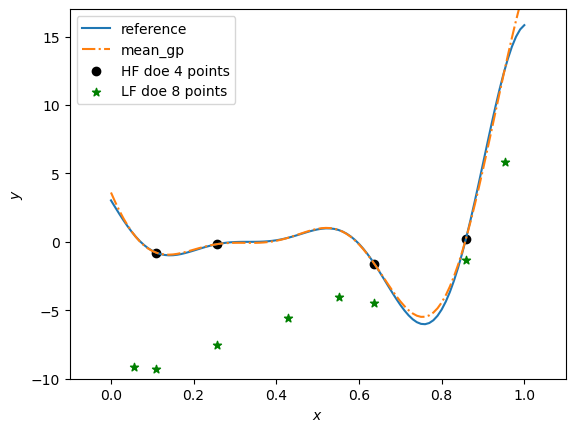

In [16]:
# plot the outputs
plt.plot(x, HF_function(x), label="reference")
plt.plot(x, y, linestyle="-.", label="mean_gp")
plt.scatter(
    Xt_e, yt_e, marker="o", color="k", label="HF doe " + str(ndoe_HF) + " points"
)
plt.scatter(
    Xt_c, yt_c, marker="*", color="g", label="LF doe " + str(ndoe_LF) + " points"
)

plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

In [17]:
# Accessing the variance and derivative of the model
MSE = sm.predict_variances(x)
der = sm.predict_derivatives(x, kx=0)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0019593
   
   Prediction time/pt. (sec) :  0.0000194
   


Text(0, 0.5, '$y$')

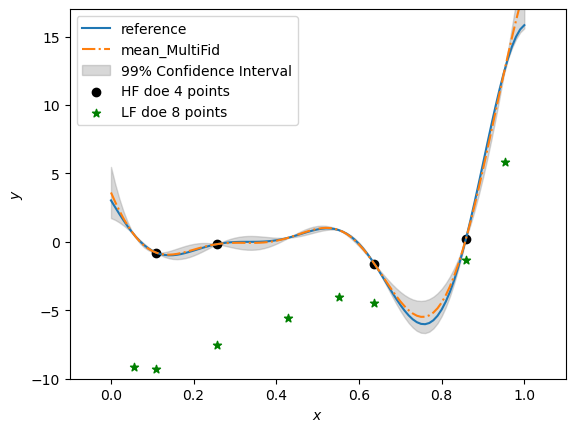

In [18]:
# plot the variance
plt.plot(x, HF_function(x), label="reference")
plt.plot(x, y, linestyle="-.", label="mean_MultiFid")
plt.fill_between(
    np.ravel(x),
    np.ravel(y - 3 * np.sqrt(MSE)),
    np.ravel(y + 3 * np.sqrt(MSE)),
    color="grey",
    alpha=0.3,
    label="99% Confidence Interval",
)

plt.scatter(
    Xt_e, yt_e, marker="o", color="k", label="HF doe " + str(ndoe_HF) + " points"
)
plt.scatter(
    Xt_c, yt_c, marker="*", color="g", label="LF doe " + str(ndoe_LF) + " points"
)

plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 8
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1793234
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0781665
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (s

Text(0, 0.5, '$y$')

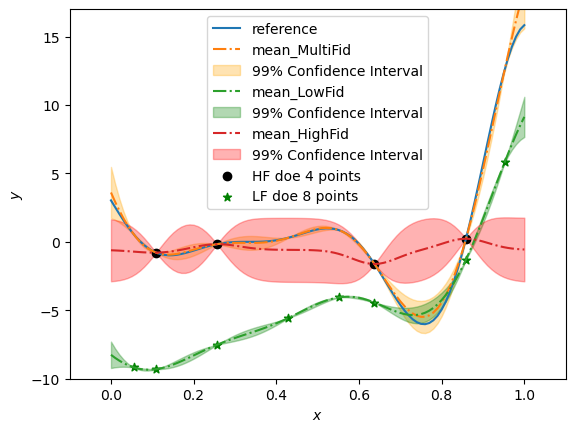

In [25]:
# build the Low fidelity  kriging
gp_LF = KRG(theta0=Xt_c.shape[1] * [1.0])
gp_LF.set_training_values(Xt_c, yt_c)
gp_LF.train()

# build the high fidelity  kriging
gp_HF = KRG(theta0=Xt_e.shape[1] * [1.0])
gp_HF.set_training_values(Xt_e, yt_e)
gp_HF.train()

# test training
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
# query the outputs
ypred_LF = gp_LF.predict_values(x)
ypred_HF = gp_HF.predict_values(x)

MSE_LF = gp_LF.predict_variances(x)
MSE_HF = gp_HF.predict_variances(x)

# plot the variance
plt.plot(x, HF_function(x), label="reference")
plt.plot(x, y, linestyle="-.", label="mean_MultiFid")
plt.fill_between(
    np.ravel(x),
    np.ravel(y - 3 * np.sqrt(MSE)),
    np.ravel(y + 3 * np.sqrt(MSE)),
    color="orange",
    alpha=0.3,
    label="99% Confidence Interval",
)

plt.plot(x, ypred_LF, linestyle="-.", label="mean_LowFid")
plt.fill_between(
    np.ravel(x),
    np.ravel(ypred_LF - 3 * np.sqrt(MSE_LF)),
    np.ravel(ypred_LF + 3 * np.sqrt(MSE_LF)),
    color="green",
    alpha=0.3,
    label="99% Confidence Interval",
)


plt.plot(x, ypred_HF, linestyle="-.", label="mean_HighFid")
plt.fill_between(
    np.ravel(x),
    np.ravel(ypred_HF - 3 * np.sqrt(MSE_HF)),
    np.ravel(ypred_HF + 3 * np.sqrt(MSE_HF)),
    color="red",
    alpha=0.3,
    label="99% Confidence Interval",
)


plt.scatter(
    Xt_e, yt_e, marker="o", color="k", label="HF doe " + str(ndoe_HF) + " points"
)
plt.scatter(
    Xt_c, yt_c, marker="*", color="g", label="LF doe " + str(ndoe_LF) + " points"
)

plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

<div class="alert alert-danger" >
<p> In most of the surrogate models $y\in\mathbb{R}$, so if you have multiple outputs $y\in\mathbb{R}^d$ (which are considered as independant outputs), add an external loop to build one surrogate model per output. The correlations betweens outputs are not taken into account.
</div>

## 2- Build a multifidelity model using  three fidelity levels


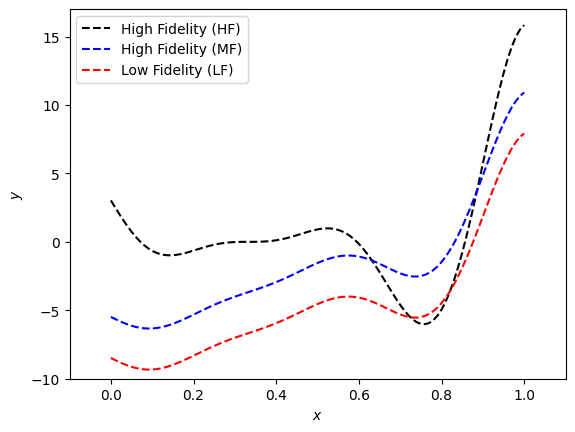

In [10]:
def LF_function(x):
    return 0.5 * ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2) + (x - 0.5) * 10.0 - 5


def MF_function(x):
    return LF_function(x) + 3


def HF_function(x):
    return ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2)


x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

plt.figure()
plt.plot(x, HF_function(x), "--k", label="High Fidelity (HF)")
plt.plot(x, MF_function(x), "--b", label="High Fidelity (MF)")
plt.plot(x, LF_function(x), "--r", label="Low Fidelity (LF)")
plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

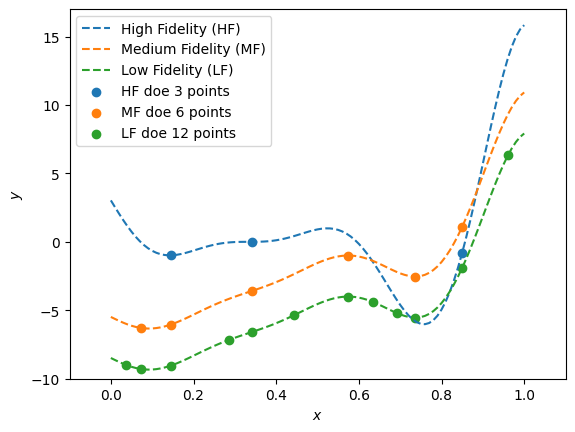

In [69]:
# LHS sampling with nested DOE: 3 levels, 1 dimension, 3 HF points
ndim = 1
nlvl = 3
ndoe_hf = 3

# Nested DOE
xlimits = np.array([[0.0, 1.0]])
xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits, random_state=2)
Xt_c, Xt_m, Xt_e = xdoes(ndoe_hf)

ndoe_lf = np.shape(Xt_c)[0]
ndoe_mf = np.shape(Xt_m)[0]

# Expensive DOE with 3 points = Xt_e
# Intermediate DOE with 6 points = Xt_m
# Cheap DOE with 16 points Xt_c


# Evaluate the HF and LF functions
yt_e = HF_function(Xt_e)
yt_m = MF_function(Xt_m)
yt_c = LF_function(Xt_c)


plt.figure()
plt.plot(x, HF_function(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, MF_function(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, LF_function(x), "--C2", label="Low Fidelity (LF)")
plt.scatter(
    Xt_e, yt_e, marker="o", color="C0", label="HF doe " + str(ndoe_hf) + " points"
)
plt.scatter(
    Xt_m, yt_m, marker="o", color="C1", label="MF doe " + str(ndoe_mf) + " points"
)
plt.scatter(
    Xt_c, yt_c, marker="o", color="C2", label="LF doe " + str(ndoe_lf) + " points"
)

plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In [70]:
# Build the MFK object with 3 levels
sm = MFK(theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt="TNC")
# low-fidelity dataset names being integers from 0 to level-1
sm.set_training_values(Xt_c, yt_c, name=0)
sm.set_training_values(Xt_m, yt_m, name=1)
# high-fidelity dataset without name
sm.set_training_values(Xt_e, yt_e)
# train the model
sm.train()


# test
nlvl = len(sm.X)
# query the outputs
y = sm.predict_values(x)
y0 = sm._predict_intermediate_values(x, 1)
y1 = sm._predict_intermediate_values(x, 2)
var = sm.predict_variances(x)
varAll, _ = sm.predict_variances_all_levels(x)
var0 = varAll[:, 0].reshape(-1, 1)
var1 = varAll[:, 1].reshape(-1, 1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...


/usr/local/lib/python3.10/dist-packages/smt/surrogate_models/krg_based.py:968: UserWarning: R is too ill conditioned. Poor combination of regression model and observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/smt/surrogate_models/krg_based.py:968: UserWarning: R is too ill conditioned. Poor combination of regression model and observations.
  warnings.warn(


   Training - done. Time (sec):  0.7430420
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0036941
   
   Prediction time/pt. (sec) :  0.0000366
   


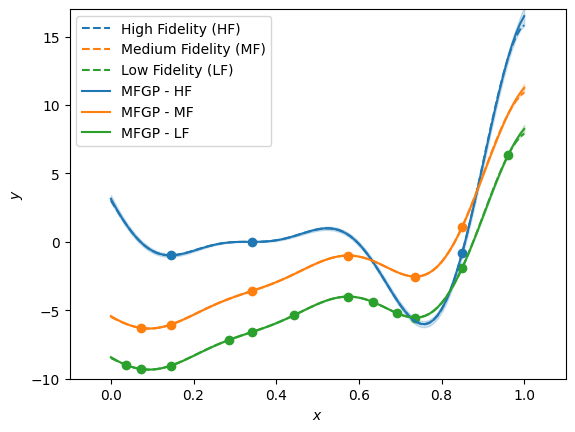

In [71]:
plt.figure()

plt.plot(x, HF_function(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, MF_function(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, LF_function(x), "--C2", label="Low Fidelity (LF)")
plt.plot(x, y, "C0", label="MFGP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y - 3 * np.sqrt(var)),
    np.ravel(y + 3 * np.sqrt(var)),
    color="C0",
    alpha=0.2,
)  # ,label ='Confidence Interval 99% HF')
plt.plot(x, y1, "C1", label="MFGP - MF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y1 - 3 * np.sqrt(var1)),
    np.ravel(y1 + 3 * np.sqrt(var1)),
    color="C1",
    alpha=0.2,
)  # ,label ='Confidence Interval 99% MF')
plt.plot(x, y0, "C2", label="MFGP - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y0 - 3 * np.sqrt(var0)),
    np.ravel(y0 + 3 * np.sqrt(var0)),
    color="C2",
    alpha=0.2,
)  # ,label ='Confidence Interval 99% LF')
plt.scatter(Xt_e, yt_e, marker="o", color="C0")  # , label='HF doe')
plt.scatter(Xt_m, yt_m, marker="o", color="C1")  # , label='MF doe')
plt.scatter(Xt_c, yt_c, marker="o", color="C2")  # , label='LF doe')
plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In [72]:
# to get some hyperparameter values
print("optimal theta:", sm.optimal_theta)

optimal theta: [array([1.22376042]), array([1.e-06]), array([1.e-06])]


In [73]:
# to compute the variance of HF model at training points
# query the outputs
y_train = sm.predict_values(Xt_e)
# y0_train = sm2._predict_intermediate_values(x, 1)
var_train = sm.predict_variances(Xt_e)
# relatve error at training points
t_error = np.linalg.norm(y_train - yt_e) / np.linalg.norm(yt_e)
# self.assert_error(t_error, 0.0, 1e-2)
print("Relative prediction error on training points", t_error)
print("Variance at training points", np.linalg.norm(var_train))

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 3
   
   Predicting ...
   Predicting - done. Time (sec):  0.0022340
   
   Prediction time/pt. (sec) :  0.0007447
   
Relative prediction error on training points 4.2460275663131205e-07
Variance at training points 0.007604705243636273
